# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [635]:
print('Welcome')

Welcome


In [637]:
# Check the present working directory
!pwd

/Users/chrismo/Documents/UdaCSP



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [921]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import re
from scipy import stats

import time

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, auc

from collections import Counter

import xgboost

from yellowbrick.cluster import KElbowVisualizer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, make_scorer, average_precision_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

# Part 1. Preprocessing

In [643]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_2466/1595624156.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')


In [644]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [645]:
print(f'The General dataset has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
#print(f'The Customers dataset has {customers.shape[0]} rows and {customers.shape[1]} columns')

The General dataset has 891221 rows and 366 columns


In [646]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [454]:
feat_info = pd.read_excel('attributesheet.xlsx', skiprows=[0])

In [458]:
feat_info = feat_info.drop(columns=['Unnamed: 0'])

In [460]:
feat_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,EINWOHNER,inhabitants,NaN
310,NaN,GKZ,standardized community-code,NaN
311,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [468]:
feat_info = feat_info[~feat_info['Attribute'].isna()]

In [470]:
feat_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,EINWOHNER,inhabitants,NaN
310,NaN,GKZ,standardized community-code,NaN
311,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [492]:
feat_values = pd.read_excel('valuessheet.xlsx', skiprows=1)
feat_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,NaN,NaN,2,smart
2254,NaN,NaN,NaN,3,fair supplied
2255,NaN,NaN,NaN,4,price driven
2256,NaN,NaN,NaN,5,seeking orientation


In [494]:
feat_values = feat_values.drop(columns=['Unnamed: 0'])

In [496]:
feat_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
...,...,...,...,...
2253,NaN,NaN,2,smart
2254,NaN,NaN,3,fair supplied
2255,NaN,NaN,4,price driven
2256,NaN,NaN,5,seeking orientation


In [498]:
old_feature_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [500]:
old_feature_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [ ]:
customer_list = list(customers.keys())
general_list = list(azdias.keys())

In [ ]:
np.setdiff1d(customer_list, general_list)

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Preprocessing General Population Data - AZDIAS

In [514]:
azdias.isna().sum().sort_values(ascending=False).head(30)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_VERSAND_ONLINE_QUOTE_12    257113
D19_LOTTO                      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_LETZTER_KAUF_BRANCHE       257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_TELKO_ONLINE_QUOTE_12      257113
KBA05_DIESEL                   133324
KBA05_CCM4                     133324
KBA05_GBZ                      133324
KBA05_FRAU                     133324
KBA05_ZUL4                     133324
KBA05_HERST1                   133324
KBA05_HERST2                   133324
KBA05_HERST3                   133324
KBA05_CCM3                     133324
KBA05_HERST5                   133324
KBA05_KRSAQU

In [516]:
(azdias.isna().sum()/azdias.shape[0]*100).sort_values(ascending=False).head(50)

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_LOTTO                      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
KBA05_DIESEL                   14.959701
KBA05_CCM4                     14.959701
KBA05_GBZ                      14.959701
KBA05_FRAU                     14.959701
KBA05_ZUL4                     14.959701
KBA05_HERST1                   14.959701
KBA05_HERST2                   14.959701
KBA05_HERST3                   14.959701
KBA05_CCM3      

Having data above 50% missing calls for further investigation

In [651]:
missing_sorted = (azdias.isna().sum()/azdias.shape[0]*100).sort_values(ascending=False).head(50)  #missing values in oly the top 50 columns

''

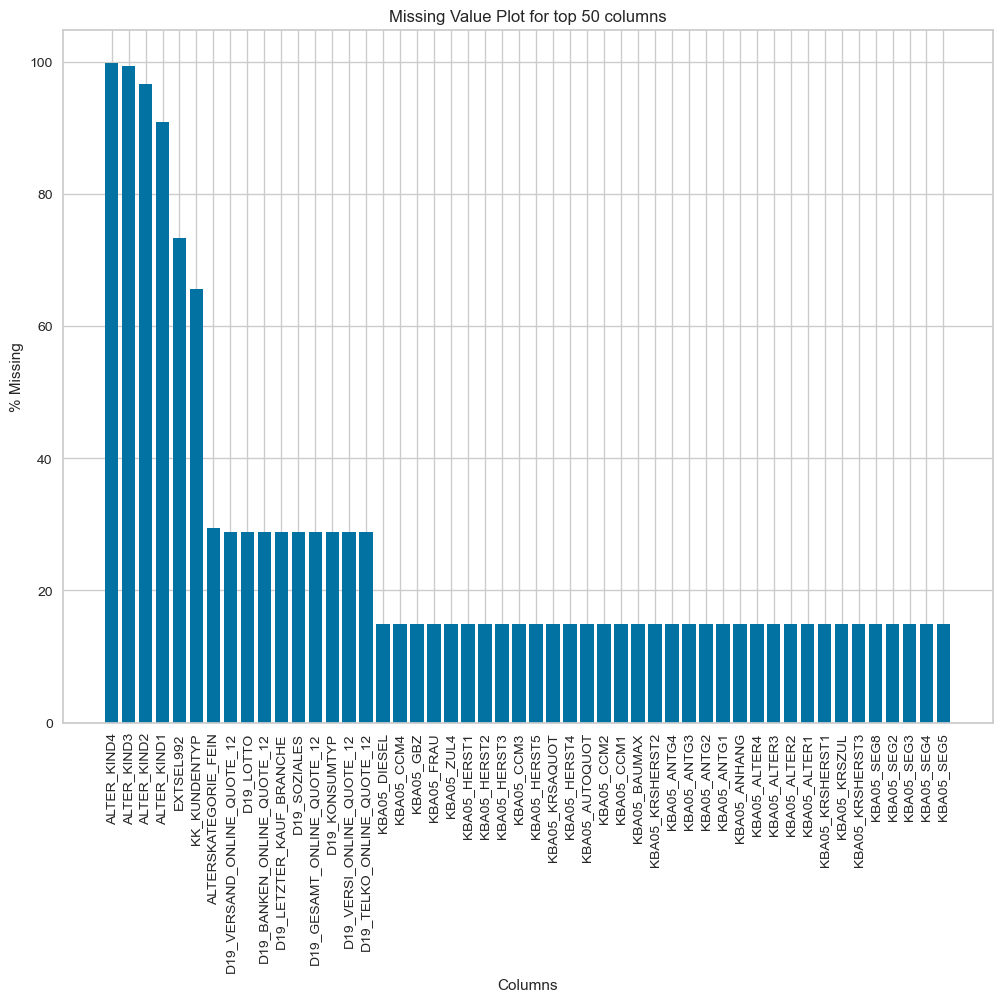

In [653]:
plt.figure(figsize=(12, 9))
plt.bar(missing_sorted.index, missing_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('% Missing')
plt.title('Missing Value Plot for top 50 columns')
;

In [656]:
(azdias.isna().sum()/azdias.shape[0]*100).sort_values(ascending=False).head(20)

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_LOTTO                      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
KBA05_DIESEL                   14.959701
KBA05_CCM4                     14.959701
KBA05_GBZ                      14.959701
KBA05_FRAU                     14.959701
dtype: float64

We have opted not to delete dimensions greater than 20% of them lost, This is simply because they contain banking data. This can easily be a huge factor for us really

In [ ]:
high_missing_list = ['ALTER_KIND4','ALTER_KIND3','ALTER_KIND2','ALTER_KIND1','EXTSEL992','KK_KUNDENTYP']

In [ ]:
for col in high_missing_list:
    print(azdias[col].value_counts())
    print("-------")

Sidenote: The columns in `high_missing_list` were examined in the dictionary provided, and no result was found for any of them

In [ ]:
print(f'Total data shape is {azdias.shape[0]}')
azdias.nunique().sort_values(ascending=False).head(30)

In [ ]:
azdias['LNR'].value_counts()

Having a column with such high dimensionality would definitely be hurtful for our entire analysis, we have to drop it 

In [ ]:
high_dimensionality_list = ['LNR']

In [ ]:
valueless_columns = []

for col in azdias.columns:
    try:
        azdias[col].plot(kind='hist')
        plt.title(f'Box plot for {col}')
        plt.show()
    except TypeError:
        valueless_columns.append(col)
        continue

#### Seeing the Histograms we investigate the two columns `D19_TELKO_ONLINE_QUOTE_12` and `D19_VERSI_ONLINE_QUOTE_12` further

In [ ]:
azdias['D19_TELKO_ONLINE_QUOTE_12'].value_counts()

In [ ]:
azdias['D19_VERSI_ONLINE_QUOTE_12'].value_counts()

In [ ]:
azdias['D19_VERSI_ONLINE_QUOTE_12'].plot(kind='hist')

In [ ]:
azdias['D19_TELKO_ONLINE_QUOTE_12'].plot(kind='hist')

In [ ]:
valueless_columns

In [ ]:
for col in valueless_columns:
    print(azdias[col].unique().tolist())
    print('------------------------------------------------')
    print(f'These are the values in the "{col}" column\n\n\n')

In [ ]:
azdias['EINGEFUEGT_AM'].nunique()

From understanding our excel sheet `DIAS ATTRIBUTE - Values 2017`, we can make these estimations:

`CAMEO_DEU_2015`: The XX, n values should be treated as nulls, while the alphabets behind the column values dropped

`CAMEO_DEUG_2015`: X, n values as nulls and convert the rests to float

`CAMEO_INTL_2015`: Conversion to type float

`D19_LETZTER_KAUF_BRANCHE`: Contains other Informative columns but they have a very inconsistent format so we drop them

`EINGEFUEGT_AM`: To be converted to datetime, feature engineering would follow from there

`OST_WEST_KZ`: 'n' columns as nulls, encoding the other 2 values

In [ ]:
azdias['CAMEO_DEUG_2015'].unique()

In [ ]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X':np.nan, 'XX':np.nan, 'n':-1})

In [ ]:
azdias['CAMEO_DEUG_2015'].unique()

In [ ]:
azdias['ALTER_HH'].value_counts()

In [ ]:
azdias['D19_BANKEN_DIREKT'].value_counts()

In [ ]:
azdias.keys().to_list()

In [ ]:
cameo_mapping = {
    "1A": "Work-Life-Balance",
    "1B": "Wealthy Best Ager",
    "1C": "Successful Songwriter",
    "1D": "Old Nobility",
    "1E": "City Nobility",
    "2A": "Cottage Chic",
    "2B": "Noble Jogger",
    "2C": "Established Gourmet",
    "2D": "Fine Management",
    "3A": "Career & Family",
    "3B": "Powershopping Families",
    "3C": "Rural Neighborhood",
    "3D": "Secure Retirement",
    "4A": "Family Starter",
    "4B": "Family Life",
    "4C": "String Trimmer",
    "4D": "Empty Nest",
    "4E": "Golden Age",
    "5A": "Younger Employees",
    "5B": "Suddenly Family",
    "5C": "Family First",
    "5D": "Stock Market Junkies",
    "5E": "Coffee Rider",
    "5F": "Active Retirement",
    "6A": "Jobstarter",
    "6B": "Petty Bourgeois",
    "6C": "Long-established",
    "6D": "Sportgardener",
    "6E": "Urban Parents",
    "6F": "Frugal Aging",
    "7A": "Journeyman",
    "7B": "Mantaplatte",
    "7C": "Factory Worker",
    "7D": "Rear Window",
    "7E": "Interested Retirees",
    "8A": "Multi-cultural",
    "8B": "Young & Mobile",
    "8C": "Prefab",
    "8D":  "Town Seniors",
    "9A": "First Shared Apartment",
    "9B": "Temporary Workers",
    "9C": "Afternoon Talk Show",
    "9D": "Mini-Jobber",
    "9E": "Socking Away"}
    
    

In [ ]:
# Map the codes to descriptions
azdias['CAMEO_Description'] = azdias['CAMEO_DEU_2015'].map(cameo_mapping)

# Encode the resulting descriptions using one-hot encoding
encoded_df = pd.get_dummies(azdias['CAMEO_Description'], prefix='CAMEO')

# Combine with the original DataFrame
final_df = pd.concat([azdias, encoded_df], axis=1)

In [ ]:
assert valueless_columns == azdias.select_dtypes(include='object').keys().to_list()

In [532]:
feat_info = pd.read_csv('feature_info.csv')

In [534]:
feat_info.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"-1, 0",unknown
4,BALLRAUM,distance to next urban centre,-1,unknown


Dropping and cleaning feat_info dataframe

In [537]:
feat_info.columns

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [539]:
feat_info.drop(columns=['Unnamed: 2', 'Unnamed: 4'], inplace=True)

In [541]:
feat_info.rename(columns={'Unnamed: 1':'Attributes', 'Unnamed: 3':'Values'}, inplace=True)

In [543]:
feat_info.head()

,Attributes,Values
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ALTER_HH,0
3,ANREDE_KZ,"-1, 0"
4,BALLRAUM,-1


We therefore use feat_info to clean out our Azdias dataframe

##### Summary: From above code we understand this is all the wrangling needed for our Categorical columns

## General Cleaning Function

In [1066]:
def clean_data(df: pd.DataFrame, reference_df: pd.DataFrame=feat_info) -> pd.DataFrame:
    """
    Cleans the entire dataframe based on specified criteria.
    
    Args: 
        df (pd.DataFrame) - dataframe for wrangling
        reference_df (pd.DataFrame) - reference dataframe for decoding 
        
    Return: df (pd.DataFrame) - cleaned dataframe
    """
    # Replace specific values with NaN
    df = df.replace({'X': np.nan, 'XX': np.nan, 'n': np.nan})

    def encode_nan(original_df, reference_df):
        # Extract column names and corresponding values to be encoded as NaN
        unique_columns = reference_df['Attributes'].tolist()
        corresponding_values = reference_df['Values'].tolist()
        
        # Iterate over each column and value pair
        for col, values in zip(unique_columns, corresponding_values):
            if col in original_df.columns:
                # Split multiple values and replace each with NaN
                for value in str(values).split(','):
                    original_df.loc[original_df[col] == int(value.strip()), col] = np.nan
        return original_df
    
    # Apply encoding function
    df = encode_nan(df, reference_df)

    decade_dictionary ={1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13: 80, 
                        14:90, 15:90} 
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dictionary) 
    
    # Process date column
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
        df['year'] = df['EINGEFUEGT_AM'].dt.year
        df['month'] = df['EINGEFUEGT_AM'].dt.month
        df['day_of_week'] = df['EINGEFUEGT_AM'].dt.dayofweek

    # Drop specified columns
    columns_to_drop = ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 
                       'EXTSEL992', 'KK_KUNDENTYP', 'D19_LETZTER_KAUF_BRANCHE', 
                       'LNR', 'EINGEFUEGT_AM', 'D19_TELKO_ONLINE_QUOTE_12', 
                       'D19_VERSI_ONLINE_QUOTE_12','PRAEGENDE_JUGENDJAHRE', 'ALTERSKATEGORIE_FEIN',
                       'D19_VERSAND_ONLINE_QUOTE_12','D19_LOTTO','D19_BANKEN_ONLINE_QUOTE_12',
                       'D19_LETZTER_KAUF_BRANCHE','D19_SOZIALES','D19_GESAMT_ONLINE_QUOTE_12',
                       'D19_KONSUMTYP','D19_VERSI_ONLINE_QUOTE_12','D19_TELKO_ONLINE_QUOTE_12']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode OST_WEST_KZ
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Map CAMEO_DEU_2015 to descriptions
    cameo_mapping = {
        "1A": "Work-Life-Balance", "1B": "Wealthy Best Ager", "1C": "Successful Songwriter",
        "1D": "Old Nobility", "1E": "City Nobility", "2A": "Cottage Chic",
        "2B": "Noble Jogger", "2C": "Established Gourmet", "2D": "Fine Management",
        "3A": "Career & Family", "3B": "Powershopping Families", "3C": "Rural Neighborhood",
        "3D": "Secure Retirement", "4A": "Family Starter", "4B": "Family Life",
        "4C": "String Trimmer", "4D": "Empty Nest", "4E": "Golden Age",
        "5A": "Younger Employees", "5B": "Suddenly Family", "5C": "Family First",
        "5D": "Stock Market Junkies", "5E": "Coffee Rider", "5F": "Active Retirement",
        "6A": "Jobstarter", "6B": "Petty Bourgeois", "6C": "Long-established",
        "6D": "Sportgardener", 
	"6E":"Urban Parents","6F":"Frugal Aging","7A":"Journeyman","7B":"Mantaplatte",
	"7C":"Factory Worker","7D":"Rear Window","7E":"Interested Retirees",
	"8A":"Multi-cultural","8B":"Young & Mobile","8C":"Prefab","8D":"Town Seniors",
	"9A":"First Shared Apartment","9B":"Temporary Workers","9C":"Afternoon Talk Show",
	"9D":"Mini-Jobber","9E":"Socking Away"
    }
    
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_Description'] = df['CAMEO_DEU_2015'].map(cameo_mapping)
        df = df.drop(columns=['CAMEO_DEU_2015'])
    
    # One-hot encode CAMEO_Description
    if 'CAMEO_Description' in df.columns:
	    df = pd.get_dummies(df, columns=['CAMEO_Description'], prefix='CAMEO')

    # Impute missing values
    for column in df.columns:
        if df[column].dtype == 'object':
            mode_value = df[column].mode()[0] if not df[column].mode().empty else ''
            df[column] = df[column].fillna(mode_value)
        else:
            median_value = df[column].median() if not np.isnan(df[column].median()) else 0
            df[column] = df[column].fillna(median_value)

    df = df.astype('int')
    
    return df


In [660]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_2466/4216581686.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')


In [661]:
df = clean_data(azdias)

In [662]:
df.isna().sum().sum()

0

In [663]:
df.shape

(891221, 394)

In [668]:
df.select_dtypes(include='object').keys()   #confirming we have no OBJECT columns left

Index([], dtype='object')

# Part 2. Feature Transformation

Looking at every value counts we have using the histogram plotted earlier, we see a wide wide range of distributed values. For this reason, we have to scale each column wrt. its standard deviation

In [572]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,2,3,16,14,4,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,16,21,11,0,0,2,12,0,...,0,0,0,0,0,0,0,0,0,0
2,2,9,17,17,10,0,0,1,7,0,...,1,0,0,0,0,0,0,0,0,0
3,2,1,13,13,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,20,14,3,0,0,4,3,0,...,0,0,0,0,0,0,0,0,0,0


In [670]:
scaler = StandardScaler()    #making scaler instance

In [672]:
scaled_data = scaler.fit_transform(df)

In [673]:
scaled_dataframe = pd.DataFrame(scaled_data, columns = df.columns)
scaled_dataframe         #sample scaling we would do in our dataframe

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,0.200115,-0.371973,0.149547,-0.258584,-0.118316,-0.292527,-0.593390,-0.302057,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
1,0.200115,1.338692,0.149547,0.212895,-0.118316,-0.292527,0.295412,0.357993,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
2,0.200115,1.338692,0.473490,0.145541,-0.118316,-0.292527,-0.593390,-0.008701,-0.057885,-0.157818,...,4.199688,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
3,0.200115,-0.942195,-0.822281,-0.460647,-0.118316,-0.292527,-1.482193,-0.375395,-0.057885,-1.213146,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
4,0.200115,-0.942195,1.445318,-0.325938,-0.118316,-0.292527,2.073018,-0.302057,-0.057885,0.897510,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,0.200115,0.198249,0.473490,0.482312,-0.118316,-0.292527,-0.593390,0.284654,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
891217,0.200115,1.338692,0.149547,0.212895,-0.118316,-0.292527,-0.593390,0.284654,-0.057885,0.897510,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
891218,0.200115,-0.942195,0.473490,-0.325938,-0.118316,-0.292527,-1.482193,-0.302057,-0.057885,-1.213146,...,4.199688,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
891219,0.200115,1.338692,0.149547,-0.056522,-0.118316,1.777488,-0.593390,-0.155379,-0.057885,0.897510,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878


In [674]:
def apply_pca(x:int=None, df:pd.DataFrame=df):
    """
    INPUT:
    x: str denoting number of components to be broken down into
    df: scaled dataframe to find principal components
    OUTPUT:
    df_pca: (np.array) denoting result
    pca: object denoting PCA's instantiation
    """
    scaler = StandardScaler()    #including scaling in function for ease
    scaled_data = scaler.fit_transform(df)
    pca = PCA(n_components=x, random_state = 42)       #ensuring reproducability
    df_pca = pca.fit_transform(scaled_data)
    return pca, df_pca

In [678]:
pca, df_pca = apply_pca()         #base pca with 0 components

In [679]:
pca

PCA(random_state=42)

In [680]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 11))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')

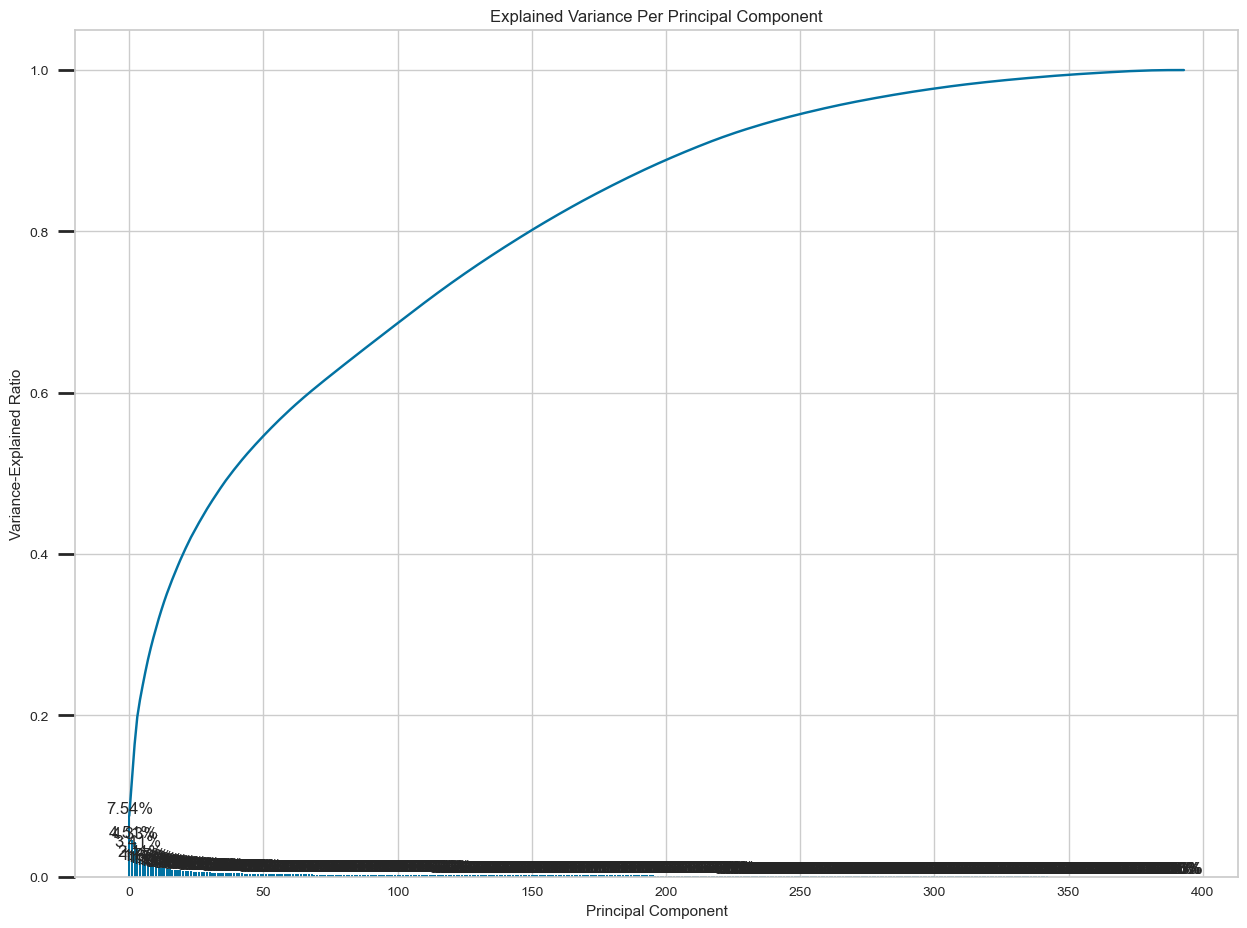

In [684]:
scree_plot(pca)

In [686]:
def pca_results(full_dataset:pd.DataFrame, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = ['Dimension {}'.format(x) for x in range(1,len(pca.components_)+1)]

	# PCA components as a dataframe on their own
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance as another dataframe
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (15,10))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [688]:
ls

AZDIAS_Feature_Summary.csv     dmail.csv
Arvato Project Workbook.ipynb* excelfiles/
Untitled.ipynb                 feature_info.csv
Untitled1.ipynb                hehe.csv
attributesheet.xlsx            valuessheet.xlsx
data/


### Here, we choose to perform out PCA upto a 90% explained variability as explained in this [post](https://www.linkedin.com/advice/3/how-can-you-determine-optimal-number-principal-4opaf)

Setting a 90% cumulative explained variance threshold compresses our data, retaining most of the original information while significantly reducing the number of features/columns. This balances dimensionality reduction with preserving key data patterns

Note: This threshold is always set by business product managers / stakeholders

In [690]:
df.shape

(891221, 394)

From scree plot, we see `215` components are just about right

In [693]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,2,3,16,4,0,0,1,3,0,3,...,0,0,0,0,0,0,0,0,0,0
1,2,9,16,11,0,0,2,12,0,3,...,0,0,0,0,0,0,0,0,0,0
2,2,9,17,10,0,0,1,7,0,3,...,1,0,0,0,0,0,0,0,0,0
3,2,1,13,1,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4,2,1,20,3,0,0,4,3,0,4,...,0,0,0,0,0,0,0,0,0,0


In [695]:
pca, df_pca = apply_pca(215, df)

In [696]:
pca

PCA(n_components=215, random_state=42)

0.9042000000000001


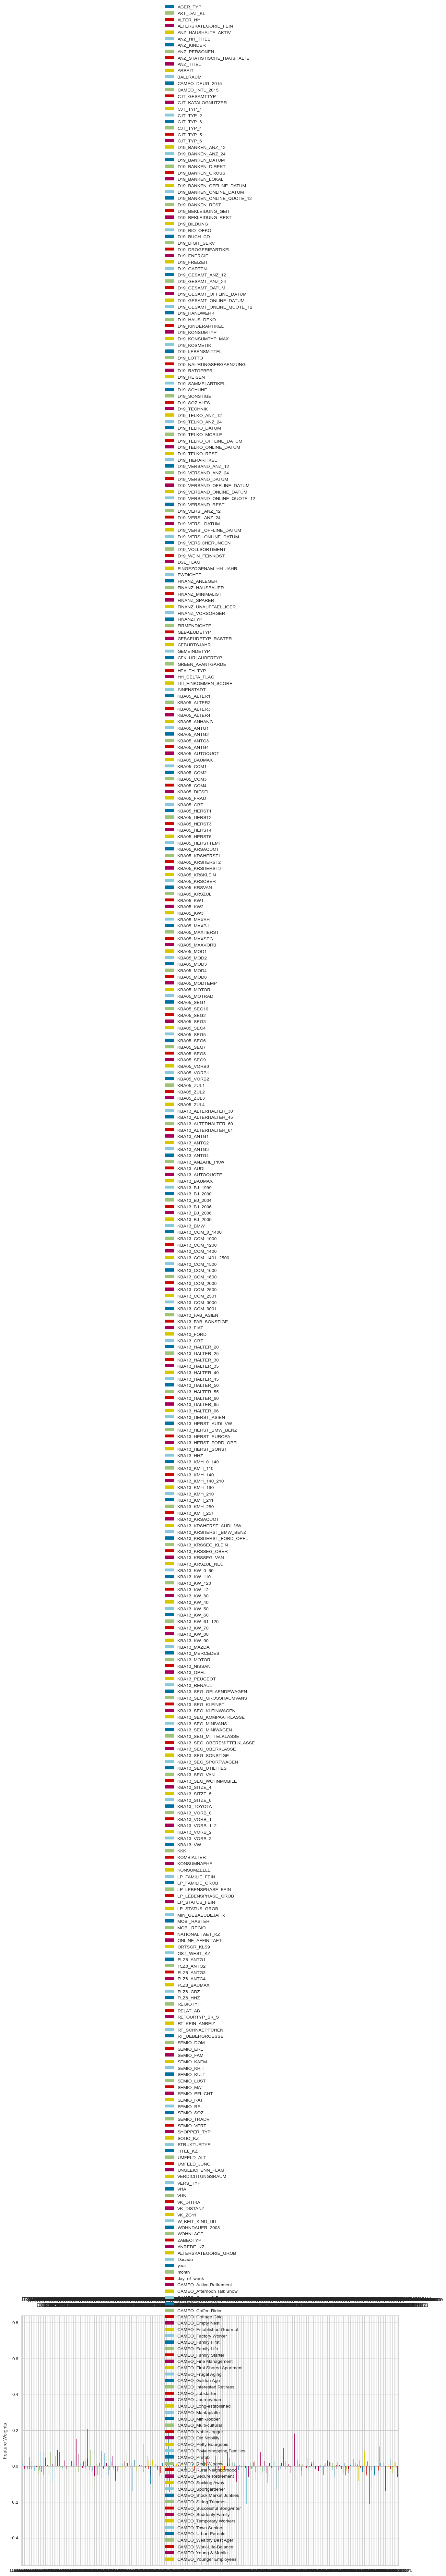

In [603]:
print(pca_results(df, pca)['Explained Variance'].sum());            #investigating variance for each threshold

In [699]:
def weights(n:int, pca, df:pd.DataFrame) -> pd.DataFrame:
    """
    INPUT: 
    n(int): index ot principal component to analyze
    pca(sklearn.decomposition.PCA): a PCA fitted object containing eigen vectors
    df(pd.DataFrame): a dataframe to examine weights

    OUTPUT: 
    df(pd.DataFrame): result dataframe having columns as index, and corresponding weights
    """
    
    col_list = list(df.keys())
    weight=list(pca.components_[n])
    
    df =pd.DataFrame(list(zip(col_list, weight)))
    df = df.set_axis(['Dimension', 'Weights'], axis=1)
    df = df.sort_values(by=['Weights'] , ascending=False)
    df.set_index('Dimension', inplace=True)
    
    return df

In [701]:
final_comp = weights(214, pca, df)          #214 because pca_components_ are zero indexed

In [703]:
final_comp

,Weights
Dimension,
D19_HAUS_DEKO,0.241017
KBA13_SEG_MINIWAGEN,0.216106
ZABEOTYP,0.204113
KBA05_ANHANG,0.187266
day_of_week,0.181260
...,...
SEMIO_MAT,-0.129691
D19_BUCH_CD,-0.138515
WOHNLAGE,-0.154177


In [705]:
#plt.figure(figsize=(12, len(final_comp) * 0.5))  # Adjust figure size based on number of dimensions
#plt.bar(final_comp.index, final_comp['Weights'])
#plt.title(f'Weights of 1 Principal Component')
##plt.xlabel('Weight')
#plt.ylabel('Dimension')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show();

You can remove comments and run the graphs

#### Applying Clustering to Population Data

In [709]:
df_pca

array([[-2.40608888,  2.07123   , -3.73683625, ..., -0.10046465,
         0.66201061,  0.15940638],
       [-4.72264625,  3.71586584,  5.0980797 , ..., -0.60276075,
         0.09315297,  0.07835419],
       [ 0.54128605,  3.34543895, -0.0757302 , ..., -0.6167494 ,
         0.51773796, -0.05443871],
       ...,
       [ 4.22971047, -0.66717558,  2.32956996, ...,  0.49816685,
         1.03185162, -0.1498975 ],
       [-7.60991378, -6.58946352,  1.44078345, ..., -0.15319027,
         0.1810801 , -0.24916804],
       [-0.36517531,  2.88569866, -5.51875747, ...,  0.73627021,
         0.15320223, -0.13175656]])

##### Using Yellowbricks's [KElbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) automated library to find optimal number of clusters for KMeans Clustering as used [here](https://atsushihara.medium.com/finding-the-optimal-cluster-size-with-yellowbrick-f0d2df9d107b)

In [712]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,2,3,16,4,0,0,1,3,0,3,...,0,0,0,0,0,0,0,0,0,0
1,2,9,16,11,0,0,2,12,0,3,...,0,0,0,0,0,0,0,0,0,0
2,2,9,17,10,0,0,1,7,0,3,...,1,0,0,0,0,0,0,0,0,0
3,2,1,13,1,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4,2,1,20,3,0,0,4,3,0,4,...,0,0,0,0,0,0,0,0,0,0


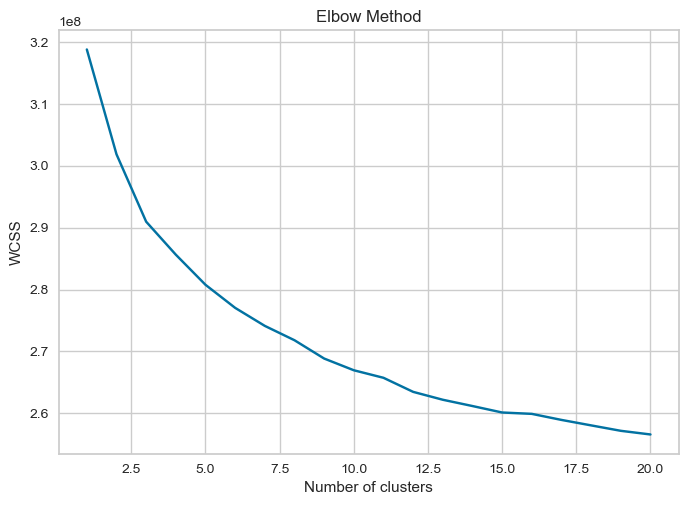

In [714]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [613]:
try:
    Elbow_M = KElbowVisualizer(KMeans(), k=(2,30))   #30 is the max expected number of clusters really
    Elbow_M.fit(df_pca)
    Elbow_M.show()
except Exception as e:
    print(f"An error occurred: {e}")

KeyboardInterrupt: 

Having our number of clusters equalling `10` from KELbow, we can build our model

In [717]:
kmeans = KMeans(n_clusters=10, random_state=42) 

In [719]:
model = kmeans.fit(df_pca)

In [721]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_2466/3966728686.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [722]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


We need to wrangle these dimensions here really

In [726]:
customers = customers.drop(columns=['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP'])

In [728]:
customer_df = clean_data(customers)

In [729]:
customer_df.isna().sum().sum()      #validating function

0

In [732]:
pca

PCA(n_components=215, random_state=42)

#### Imputer Operations

In [735]:
scaled_customerdf = pd.DataFrame(scaler.transform(customer_df), columns=customer_df.columns)         #denoting variability explained by each column 
scaled_customerdf

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,0.200115,-0.942195,-1.794109,-0.460647,-0.118316,-0.292527,0.295412,-0.448734,-0.057885,-2.268474,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,9.007785,-0.197426,-0.117878
1,0.200115,1.338692,-1.470166,-0.460647,-0.118316,-0.292527,1.184215,-0.448734,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
2,0.200115,-0.942195,-3.089880,-0.460647,-0.118316,-0.292527,-0.593390,-0.448734,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
3,-2.370534,-0.942195,-2.441994,-0.528001,-0.118316,-0.292527,-1.482193,-0.448734,-0.057885,-2.268474,...,4.199688,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
4,0.200115,-0.942195,1.445318,-0.056522,-0.118316,-0.292527,2.073018,-0.008701,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,-2.370534,-0.942195,-2.118052,-0.460647,-0.118316,-0.292527,-0.593390,-0.448734,-0.057885,-0.157818,...,-0.238113,14.333336,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
191648,0.200115,-0.657084,-0.822281,-0.528001,-0.118316,-0.292527,-1.482193,-0.448734,-0.057885,-2.268474,...,-0.238113,-0.069767,9.223613,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
191649,0.200115,-0.942195,-0.174396,-0.460647,-0.118316,-0.292527,1.184215,-0.448734,-0.057885,-0.157818,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
191650,2.770764,-0.942195,-0.822281,-0.258584,-0.118316,-0.292527,2.073018,-0.302057,-0.057885,-0.157818,...,4.199688,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878


In [737]:
#applying PCA to scaled dataframe

customer_pca = pca.transform(scaled_customerdf)

/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [739]:
cust_model_predictions = model.predict(customer_pca) 

In [741]:
azdias_prediction

NameError: name 'azdias_prediction' is not defined

In [745]:
cust_model_predictions

array([6, 3, 9, ..., 6, 5, 4], dtype=int32)

In [ ]:
desired_clusters = [0,1,2,3,4,5,6,7,8,9,10,11]

In [ ]:
# series conversion

cust_model_predictions = pd.Series(cust_model_predictions)
azdias_prediction = pd.Series(azdias_prediction)

In [ ]:
# calculating the percentage and count covered by the cluster of the azdias data

azdias_cluster = pd.Series(azdias_prediction).value_counts().reset_index()
azdias_cluster.columns   = ['Cluster', 'Count']
azdias_cluster['Dataset'] = 'Azdias'
azdias_cluster['Percentage']  = azdias_cluster['Count'] / df.shape[0]

In [ ]:
azdias_cluster.head()

In [ ]:
print(df.shape[0])

In [ ]:
print(customers.shape[0])

In [ ]:
# calculating the percentage and count covered by the cluster of the customers data

customers_cluster = pd.Series(cust_model_predictions).value_counts().reset_index()
customers_cluster.columns   = ['Cluster', 'Count']
customers_cluster['Dataset'] = 'Customers'
customers_cluster['Percentage']  = customers_cluster['Count'] / customer_df.shape[0]

In [ ]:
customers_cluster.head()

In [ ]:
# Find the difference in the clusters for both datasets

Cluster_Diff_Perc = pd.concat([azdias_cluster.groupby(['Cluster']).agg({'Percentage': ['sum']}), 
                      customers_cluster.groupby(['Cluster']).agg({'Percentage': ['sum']}) ], axis = 1)

Cluster_Diff_Perc.columns = ['Azdias', 'Customers']
Cluster_Diff_Perc['Difference'] = Cluster_Diff_Perc['Customers'] - Cluster_Diff_Perc['Azdias']
Cluster_Diff_Perc.head()

In [ ]:
dataset_differenec = pd.concat([azdias_cluster, customers_cluster], axis = 0) 
sns.barplot(data = dataset_differenec, x = 'Cluster', y = 'Percentage', hue = 'Dataset')
plt.title("Azdias Vs Customers Distribution Plot", fontsize = 14)
plt.xlabel("Clusters")
plt.ylabel("Percentage")
plt.legend(loc='best');

Seeing we have our 0th and 5th clusters doing best,

We still need to know the qualities of the people overrepresented here

In [ ]:
cluster_0 = model.cluster_centers_[0]
pca_0 = pca.inverse_transform(cluster_0)
pca_0_2d = np.array(pca_0).reshape(1, -1)  # Reshape to 2D
overrepresented = scaler.inverse_transform(pca_0_2d)

overrepresented = pd.Series(data=overrepresented.flatten(), index=list(df.keys()))
display(overrepresented.head(45))

Our data insights show our promotional effort should be directed towards:

1. The cultural enriched,that coincides with the Non Natives in this case
2. People who live within 40 - 50 km to Urban centre

In [ ]:
from sklearn.metrics import roc_auc_score

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1068]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', delimiter=';', index_col = 'LNR')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_2466/1963665669.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', delimiter=';', index_col = 'LNR')


In [1070]:
#mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [1072]:
mailout_train.isna().sum().sum()

2217179

In [1074]:
mailout_train.shape

(42962, 366)

In [1076]:
mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [1078]:
mailout_train['RESPONSE'].value_counts()

RESPONSE
0    42430
1      532
Name: count, dtype: int64

In [1080]:
mailout_train.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,,,
1763,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
1771,5B,5.0,32.0,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
1776,2D,2.0,14.0,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
1460,2D,2.0,14.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
1783,7B,7.0,41.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
...,...,...,...,...,...,...
66338,3C,3.0,24.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W
67629,6B,6.0,43.0,D19_HAUS_DEKO,1992-02-10 00:00:00,O
68273,4A,4.0,22.0,D19_BUCH_CD,1992-02-10 00:00:00,W


In [1082]:
train_df=clean_data(mailout_train)

In [1084]:
train_df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
LNR,,,,,,,,,,,,,,,,,,,,,
1763,2,1,8,15,0,0,1,13,0,3,...,0,0,0,0,0,0,0,0,0,0
1771,1,4,13,1,0,0,2,1,0,2,...,0,0,1,0,0,0,0,0,0,0
1776,1,1,9,0,0,0,0,1,0,4,...,0,0,0,0,0,0,0,0,0,0
1460,2,1,6,4,0,0,2,4,0,4,...,0,0,0,0,0,0,0,0,0,0
1783,2,1,9,53,0,0,1,44,0,3,...,0,0,0,0,0,0,0,0,0,0


In [1086]:
train_df.isna().sum().sum()

0

In [1088]:
train_df['RESPONSE'].value_counts()

RESPONSE
0    42430
1      532
Name: count, dtype: int64

In [1090]:
postive_class = round(train_df['RESPONSE'].value_counts()[1]/(train_df['RESPONSE'].shape[0])*100, 2)
postive_class

1.24

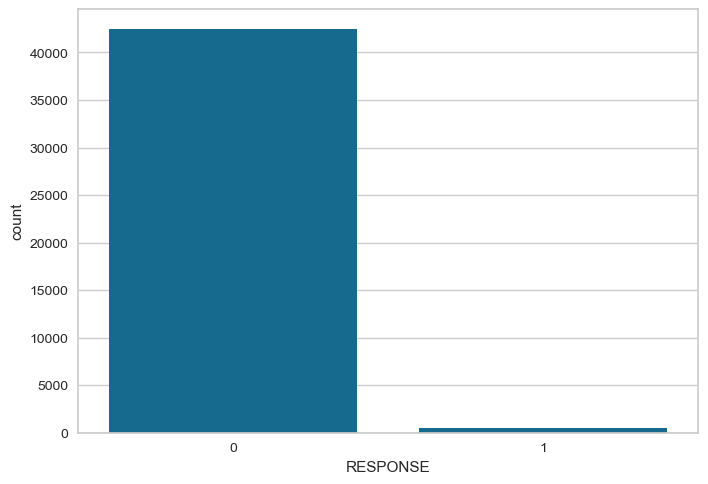

In [1092]:
sns.countplot(data=train_df, x='RESPONSE');

#### Easily we detect a very high class imbalance. Infact this class imbalance is explicitly saying only 1.24% answer our Marketting campaigns

##### Given the small proportion of customers with response = 1, we will optimize ROC-AUC rather than accuracy.

In [1118]:
X = train_df.drop(columns=['RESPONSE'], axis=1)
y = train_df['RESPONSE']

In [1120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [1122]:
# Scale the data
X_train = scaler.fit_transform(X_train)

In [1123]:
X_test = scaler.transform(X_test)

Scaling only Inputs to avoid Data Leakage

In [1189]:
def test_models(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Base models
    models = {
        'LightGBM': LGBMClassifier(class_weight='balanced', scale_pos_weight=84, random_state=42),
        'XGBoost': XGBClassifier(scale_pos_weight=84, objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50, random_state=42),
        'AdaBoost': AdaBoostClassifier(learning_rate=0.1, n_estimators=50, random_state=42)
    }

    scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, predictions)
        scores[name] = score

    return scores

In [1191]:
print(test_models())

[LightGBM] [Info] Number of positive: 426, number of negative: 33943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3259
[LightGBM] [Info] Number of data points in the train set: 34369, number of used features: 393
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
{'LightGBM': 0.6730187789982904, 'XGBoost': 0.6914253986674403, 'AdaBoost': 0.7034960238855875}


We see our best models here are Adaboost and then XGBoost really. Lets try to hyperparameter tune them

#### Hyperparameter Tuning

In [1139]:
xgb = XGBClassifier(scale_pos_weight=84, objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50, random_state=42)

In [1141]:
# Our the param grid
param_grid = {
    'scale_pos_weight': [20, 40, 84],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'alpha': [1, 5, 10],
    'n_estimators': [25, 50, 100]
}

In [1143]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    verbose=1
)

In [1145]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


/Users/chrismo/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=XGBClassifier(alpha=10, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_ra...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'alpha': [1, 5, 10],
                         'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [25, 50, 100],
                         'scale_pos_weight': [20, 40, 84]},
             verbose=1)

In [1146]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'alpha': 1, 'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 25, 'scale_pos_weight': 20}


In [1147]:
print("Best cross-validation score:", grid_search.best_score_)

Best cross-validation score: 0.9876051092344479


In [1148]:
best_xgb = grid_search.best_estimator_

In [1149]:
best_xgb.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, ...)

In [1150]:
xgb_pred = best_xgb.predict(X_test)

In [1151]:
roc_auc_score(y_test, xgb_pred)

0.5

In [1213]:
base_estimator = DecisionTreeClassifier(random_state=42)

In [1215]:
ada = AdaBoostClassifier(estimator=base_estimator, learning_rate=0.1, n_estimators=50, random_state=42)

In [1217]:
param_grid = {
    'estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

In [1229]:
grid_search = GridSearchCV(ada, param_grid, cv=3, verbose=2)

In [1239]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   4.8s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   4.7s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   4.7s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   9.5s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   9.4s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   9.4s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=200; total time=  19.0s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=200; total time=  18.8s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=200; total time=  18.7s
[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=50; total time=   4.8s
[CV] END estimator__max_depth=1, learning_ra

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                          learning_rate=0.1, random_state=42),
             param_grid={'estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [1240]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 50}


In [1241]:
print("Best cross-validation score:", grid_search.best_score_)

Best cross-validation score: 0.9876051092344479


In [1242]:
best_ada = grid_search.best_estimator_

In [1243]:
best_ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.01, random_state=42)

In [1244]:
ada_pred = best_ada.predict(X_test)

In [1245]:
roc_auc_score(y_test, ada_pred)

0.5

We can then go ahead with our XGBoost as best really

In [398]:
best_xgb.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(alpha=5, base_score=None, booster=None,
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.5,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [400]:
feature_importance = best_xgb.named_steps['clf'].feature_importances_
feature_importance

array([0.01230721, 0.        , 0.        , 0.01061463, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00476783, 0.        , 0.00895461, 0.00624364,
       0.        , 0.00941158, 0.01380092, 0.        , 0.        ,
       0.        , 0.00563564, 0.        , 0.        , 0.01136809,
       0.00986451, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00687545, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00840744, 0.00711243, 0.        ,
       0.        , 0.        , 0.        , 0.00676524, 0.        ,
       0.        , 0.03476708, 0.04671543, 0.        , 0.        ,
       0.0067439 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10288919, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00849836, 0.00879812, 0.01024

In [412]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_2466/4118961090.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [414]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [416]:
mailout_test.shape

(42833, 366)

In [418]:
test_LNR = mailout_test['LNR']

In [420]:
mailout_test = mailout_test.drop(columns=['LNR'])

In [426]:
test_df = clean_data(mailout_test)

In [430]:
test_df.isna().sum().sum()

0

In [432]:
test_df.shape

(42833, 401)

In [434]:
scaler = StandardScaler()

test_dataframe = pd.DataFrame(scaler.fit_transform(test_df))